In [1]:
import pandas as pd
import geopandas as gpd
import folium 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy.stats import linregress
import folium
from scipy.stats import pearsonr
import streamlit as st
from streamlit_folium import folium_static
from pysal.lib import weights  
import segregation as seg

C:\Users\MorrisKurz\AppData\Local\Temp\ipykernel_15556\2810799249.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# Read zensus data in 100m x 100m grid
df1 = pd.read_csv('../data_example/Zensus_Bremen_Buildings.csv', delimiter=';', index_col=0)
df2 = pd.read_csv('../data_example/Zensus_Bremen_Families.csv', delimiter=';', index_col=0)
df3 = pd.read_csv('../data_example/Zensus_Bremen_Households.csv', delimiter=';', index_col=0)
df4 = pd.read_csv('../data_example/Zensus_Bremen_Population.csv', delimiter=';', index_col=0)
df5 = gpd.read_file('../data_example/Zensus_Bremen_Grid_100m.gpkg')

In [87]:
# Load the neighborhood polygons
neighborhood_polygons = gpd.read_file('../data_example/BRW_2011_Polygon.shp')

In [3]:
# Load the neighborhood polygons
neighborhood_polygons = gpd.read_file('../data_example/Land_Prices_Neighborhood_Bremen.gpkg')

In [59]:

neighborhood_polygons

,Neighborhood_FID,Land_Value,Area_Types,Area_Count,City_Name,geometry
0,1,788.8,CommercialArea_CoreArea_Farmland_GreenArea_Res...,25,Köln,"MULTIPOLYGON (((4113844.607 3091245.039, 41138..."
1,2,874.9,CommercialArea_Farmland_ForestryArea_GreenArea...,32,Köln,"MULTIPOLYGON (((4100028.083 3096909.048, 41000..."
2,3,468.4,CommercialArea_Farmland_ForestryArea_GreenArea...,18,Köln,"MULTIPOLYGON (((4099966.963 3100961.966, 40999..."
3,4,286.0,AgriculturalArea_CommercialArea_Farmland_Green...,25,Köln,"MULTIPOLYGON (((4111198.584 3102570.697, 41112..."
4,5,652.8,Farmland_ForestryArea_Residential_SpecialUseArea,20,Köln,"MULTIPOLYGON (((4112305.385 3102700.016, 41123..."
...,...,...,...,...,...,...
81,82,88.0,AgriculturalArea_CommercialArea_Farmland_Resid...,13,Köln,"MULTIPOLYGON (((4104667.748 3107272.079, 41046..."
82,83,138.3,AgriculturalArea_Farmland_ForestryArea_Residen...,12,Köln,"MULTIPOLYGON (((4102888.748 3108552.142, 41030..."
83,84,35.0,Farmland_Residential,7,Köln,"MULTIPOLYGON (((4115750.422 3086222.340, 41158..."
84,85,435.5,CommercialArea_CoreArea_ForestryArea_GreenArea...,23,Köln,"MULTIPOLYGON (((4109233.260 3095216.098, 41092..."


In [87]:
# Merge them into a single dataframe by the column Grid_Code
merged_df = pd.merge(df1, df2, on='Grid_Code')
merged_df = pd.merge(merged_df, df3, on='Grid_Code')
merged_df = pd.merge(merged_df, df4, on='Grid_Code')
merged_df = pd.merge(merged_df, df5, on='Grid_Code')
zensus_data = gpd.GeoDataFrame(merged_df)
# Extract the grid middle points to match them later to their respective neighborhoods
zensus_data.geometry = zensus_data.geometry.centroid
# Reproject the data to use the same coordinate system
neighborhood_polygons = neighborhood_polygons.to_crs(zensus_data.crs)
# Join the grid points into the neighborhoods and group them
zensus_data_by_neighborhood = gpd.sjoin(zensus_data, neighborhood_polygons, how='left', op='within')
# Drop any non numeric data
zensus_data_by_neighborhood['BRW'] = pd.to_numeric(zensus_data_by_neighborhood.Land_Value, errors='coerce')
# Drop grid cells with not existing housing values
zensus_data_by_neighborhood = zensus_data_by_neighborhood.dropna(subset=['Land_Value'])
# Remove geometry column and add polygon areas
zensus_data_by_neighborhood = zensus_data_by_neighborhood.drop(columns=['geometry'])
zensus_data_by_neighborhood = pd.merge(zensus_data_by_neighborhood, neighborhood_polygons[['Neighborhood_FID', 'geometry']], on='Neighborhood_FID', how='left')
zensus_data_by_neighborhood_grouped = zensus_data_by_neighborhood.groupby('Neighborhood_FID')

In [88]:
# Drop un
column_names_map = {"Area_Types": "Area Type", "buildings_total_units": "Total number of buildings", "Land_Value": "Euros per square meter", "Neighborhood_FID": "Neighborhood ID", "geometry": "geometry", "sk_germany": "Amount of German citizens", "sk_abroad": "Amount of foreign citizens"}
age_group_map = {"alk_18_under": "Age Group <18", "alk_18_29": "Age Group 18-29", "alk_30_49": "Age Group 30-49", "alk_50_64": "Age Group 50-64", "alk_65_over": "Age Group >65"}
building_age_map = {'j_before_1919': "Houses with building year <1919",'j_1919_1948': "Houses with building year 1919-1948",'j_1949_1978': "Houses with building year 1948-1978",'j_1979_1995': "Houses with building year 1979-1995",'j_1996_2008': "Houses with building year 1996-2008",'j_2009_and_later': "Houses with building year >2009"}
household_map = {"hhgr_1_pers": "Household size 1", "hhgr_2_pers": "Household size 2", "hhgr_3_pers": "Household size 3", "hhgr_4_pers": "Household size 4", "hhgr_5_pers": "Household size 5", "hhgr_6_more": "Household size >=6"}
column_names_map.update(age_group_map)
column_names_map.update(building_age_map)
column_names_map.update(household_map)
zensus_data_by_neighborhood_filtered = zensus_data_by_neighborhood[column_names_map.keys()]
zensus_data_by_neighborhood_filtered = zensus_data_by_neighborhood_filtered.rename(columns=column_names_map)
zensus_data_by_neighborhood_filtered.columns

Index(['Area Type', 'Total number of buildings', 'Euros per square meter',
       'Neighborhood ID', 'geometry', 'Amount of German citizens',
       'Amount of foreign citizens', 'Age Group <18', 'Age Group 18-29',
       'Age Group 30-49', 'Age Group 50-64', 'Age Group >65',
       'Houses with building year <1919',
       'Houses with building year 1919-1948',
       'Houses with building year 1948-1978',
       'Houses with building year 1979-1995',
       'Houses with building year 1996-2008',
       'Houses with building year >2009', 'Household size 1',
       'Household size 2', 'Household size 3', 'Household size 4',
       'Household size 5', 'Household size >=6'],
      dtype='object')

In [148]:
agg_funcs = {column: 'sum' for column in column_names_map.values()}
agg_funcs.update({
    'Area Type': 'first',
    'geometry': 'first',
    'Euros per square meter': 'mean'
})
agg_funcs.pop('Neighborhood ID')

zensus_data_by_neighborhood = zensus_data_by_neighborhood_filtered.groupby("Neighborhood ID").agg(agg_funcs)

In [155]:
# Get percentage of German citizens
german = zensus_data_by_neighborhood["Amount of German citizens"]
foreign = zensus_data_by_neighborhood["Amount of foreign citizens"]
zensus_data_by_neighborhood["Percentage of German citizens"] = (german)/(german+foreign)

In [157]:
# Get number of residents per building
buildings = zensus_data_by_neighborhood["Total number of buildings"]
german = zensus_data_by_neighborhood["Amount of German citizens"]
foreign = zensus_data_by_neighborhood["Amount of foreign citizens"]
zensus_data_by_neighborhood["Amount of residents per building"] = (german+foreign)/buildings

In [168]:
# Normalize building data
buildings = zensus_data_by_neighborhood["Total number of buildings"]
[zensus_data_by_neighborhood[v]/buildings for v in building_age_map.values()]
for house_age in building_age_map.values():
    normalized = zensus_data_by_neighborhood[house_age]/buildings
    normalized.replace(np.nan, 0)
    zensus_data_by_neighborhood[house_age + ' percentage'] = normalized

In [169]:
zensus_data_by_neighborhood.head()

,Area Type,Total number of buildings,Euros per square meter,geometry,Amount of German citizens,Amount of foreign citizens,Age Group <18,Age Group 18-29,Age Group 30-49,Age Group 50-64,...,Household size 5,Household size >=6,Percentage of German citizens,Amount of residents per building,Houses with building year <1919 normalized,Houses with building year 1919-1948 normalized,Houses with building year 1948-1978 normalized,Houses with building year 1979-1995 normalized,Houses with building year 1996-2008 normalized,Houses with building year >2009 normalized
Neighborhood ID,,,,,,,,,,,,,,,,,,,,,
1.0,MixedUseArea_Residential,2419,1811.5,"MULTIPOLYGON (((4240416.102 3331179.886, 42404...",2808,876,198,1030,1317,618,...,3,0,0.762215,1.522943,0.057462,0.024804,0.732534,0.127739,0.020256,0.002067
2.0,Residential_SpecialUseArea,3412,1314.3,"MULTIPOLYGON (((4240636.917 3332085.091, 42408...",4354,969,368,1601,1606,755,...,25,12,0.817960,1.560082,0.033411,0.024033,0.855803,0.067116,0.006448,0.000000
3.0,Residential,5065,1623.7,"MULTIPOLYGON (((4242286.604 3330894.457, 42423...",7571,868,878,1784,2948,1768,...,46,30,0.897144,1.666140,0.426851,0.091807,0.279566,0.155183,0.009082,0.000000
4.0,CommercialBuildingArea_Residential,84,172.7,"MULTIPOLYGON (((4234857.715 3337708.696, 42349...",133,79,50,42,50,46,...,3,0,0.627358,2.523810,0.059524,0.238095,0.619048,0.000000,0.035714,0.000000
5.0,CommercialBuildingArea_Residential,0,90.3,"MULTIPOLYGON (((4233902.810 3335297.269, 42339...",9,0,0,0,3,3,...,0,0,1.000000,inf,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
zensus_data_by_neighborhood = zensus_data_by_neighborhood.set_crs(zensus_data.crs).to_crs(epsg=4326)

AttributeError: 'DataFrame' object has no attribute 'set_crs'

In [158]:
gpd.GeoDataFrame(zensus_data_by_neighborhood).to_file('bremen_merged_data.gpkg', driver='GPKG')

In [9]:
# Filter all neighborhoods with 100 or less persons
# Get amount of people in neighborhoods
germans_nbgh = zensus_data_by_neighborhood_grouped.sk_germany.sum()
foreign_nbgh = zensus_data_by_neighborhood_grouped.sk_abroad.sum()
amount_of_buildings_nbgh = zensus_data_by_neighborhood_grouped.buildings_total_units.sum()
people_nbgh = (germans_nbgh + foreign_nbgh)/amount_of_buildings_nbgh
# Sort out outliers
filtered_zensus_data = zensus_data_by_neighborhood_grouped.filter(lambda x: (not (germans_nbgh + foreign_nbgh <= 100)[x.name]) and (people_nbgh <= 5)[x.name])
zensus_data_by_neighborhood_grouped = filtered_zensus_data.groupby('Neighborhood ID')

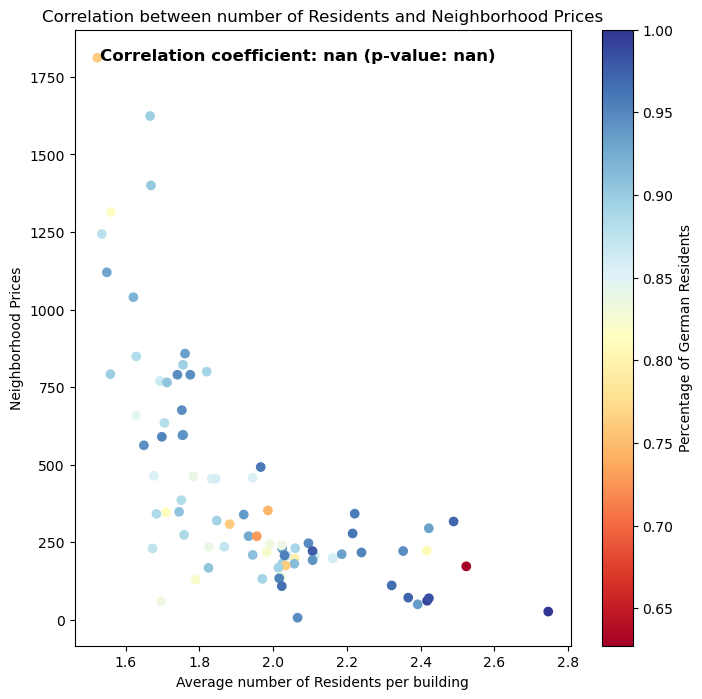

In [159]:
# Example question: How is the distribution of German residents vs. foreign residents in rich vs. poor neighborhoods?
# Get amount of people in neighborhoods
germans_nbgh = zensus_data_by_neighborhood_grouped.sk_germany.sum()
foreign_nbgh = zensus_data_by_neighborhood_grouped.sk_abroad.sum()
# Normalize by amount of buildings in the neighborhood
amount_of_buildings_nbgh = zensus_data_by_neighborhood_grouped.buildings_total_units.sum()
germans_nbgh /= amount_of_buildings_nbgh
foreign_nbgh /= amount_of_buildings_nbgh
people_nbgh = germans_nbgh+foreign_nbgh
# Plot 
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(x=people_nbgh, y=zensus_data_by_neighborhood_grouped.Land_Value.mean(), c=germans_nbgh/people_nbgh, cmap='RdYlBu', alpha=1)
# Add a color bar
cbar = plt.colorbar(scatter)
cbar.ax.set_ylabel('Percentage of German Residents')
# Add labels and title
ax.set_xlabel('Average number of Residents per building')
ax.set_ylabel('Neighborhood Prices')
ax.set_title('Correlation between number of Residents and Neighborhood Prices')
# Compute the linear regression and plot the line of best fit
slope, intercept, r_value, p_value, std_err = linregress(people_nbgh, zensus_data_by_neighborhood_grouped.Land_Value.mean())
line_x = np.array([people_nbgh.min(), people_nbgh.max()])
line_y = intercept + slope * line_x
ax.plot(line_x, line_y, color='black', linewidth=2, linestyle='--')

# Add the correlation coefficient to the plot
corr_coef_text = 'Correlation coefficient: {:.2f} (p-value: {:.2f})'.format(r_value, p_value)
ax.text(x=0.05, y=0.95, s=corr_coef_text, transform=ax.transAxes, fontsize=12, fontweight='bold')
plt.show()


In [84]:
import folium

# Create a map centered on Cologne
map = folium.Map(location=[50.938, 6.959], zoom_start=12)
# Group the data by geometry and calculate the mean of the BRW column for each group
zensus_data_by_geometry = gpd.GeoDataFrame(zensus_data_by_neighborhood).dissolve(by='Neighborhood_FID', aggfunc='sum').reset_index()
# Add the neighborhoods as polygons to the map
folium.Choropleth(
    geo_data=zensus_data_by_geometry,
    name='choropleth',
    data=zensus_data_by_geometry,
    columns=['Neighborhood_FID', 'Land_Value'],
    key_on='feature.properties.XWERT',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Land Value'
).add_to(map)

# Add a layer control to toggle the choropleth
folium.LayerControl().add_to(map)

# Display the map in Streamlit
folium_static(map)

2023-04-29 16:52:40.997 
  command:

    streamlit run c:\Users\MorrisKurz\anaconda3\envs\ifohack_spatial_py310\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()